In [2]:
import torch

def swap_top_two_softmax(tensor):
    # Find the top two values along the softmax dimension
    top2_values, top2_indices = torch.topk(tensor, 2, dim=1)
    
    # Clone the original tensor so we can modify it
    swapped_tensor = tensor.clone()
    
    # Create a tensor of batch indices
    batch_indices = torch.arange(tensor.size(0))
    
    # Get the indices of the top two values
    max_indices = top2_indices[:, 0]  # Highest value indices
    second_max_indices = top2_indices[:, 1]  # Second highest value indices
    
    # Swap the values by indexing per batch
    swapped_tensor[batch_indices, max_indices] = top2_values[:, 1]  # Place second highest value at highest index
    swapped_tensor[batch_indices, second_max_indices] = top2_values[:, 0]  # Place highest value at second highest index
    
    return swapped_tensor

# Example usage
tensor = torch.tensor([[0.1, 0.3, 0.4, 0.2],
                       [0.5, 0.2, 0.1, 0.2]])
swapped_tensor = swap_top_two_softmax(tensor)
print(swapped_tensor)

tensor([[0.1000, 0.4000, 0.3000, 0.2000],
        [0.2000, 0.5000, 0.1000, 0.2000]])


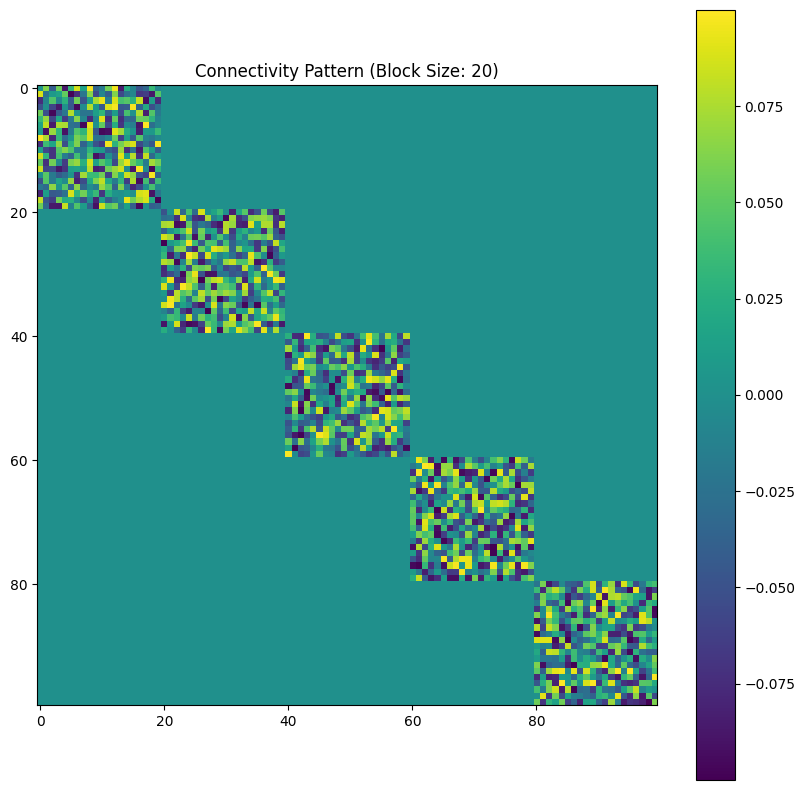

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MaskedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, block_size: int, bias: bool = True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.block_size = block_size
        self.register_buffer('mask', self.create_mask())

    def create_mask(self):
        mask = torch.zeros(self.weight.size())
        for i in range(0, self.out_features, self.block_size):
            j = i  # This ensures block diagonal structure
            mask[i:i+self.block_size, j:j+self.block_size] = 1
        return mask

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.weight * self.mask, self.bias)

    # def reset_parameters(self) -> None:
    #     super().reset_parameters()
    #     self.weight.data *= self.mask

    def visualize_connectivity(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.weight.data * self.mask, cmap='viridis')
        plt.title(f'Connectivity Pattern (Block Size: {self.block_size})')
        plt.colorbar()
        plt.show()

# Usage example:
layer = MaskedLinear(100, 100, block_size=20)
layer.visualize_connectivity()

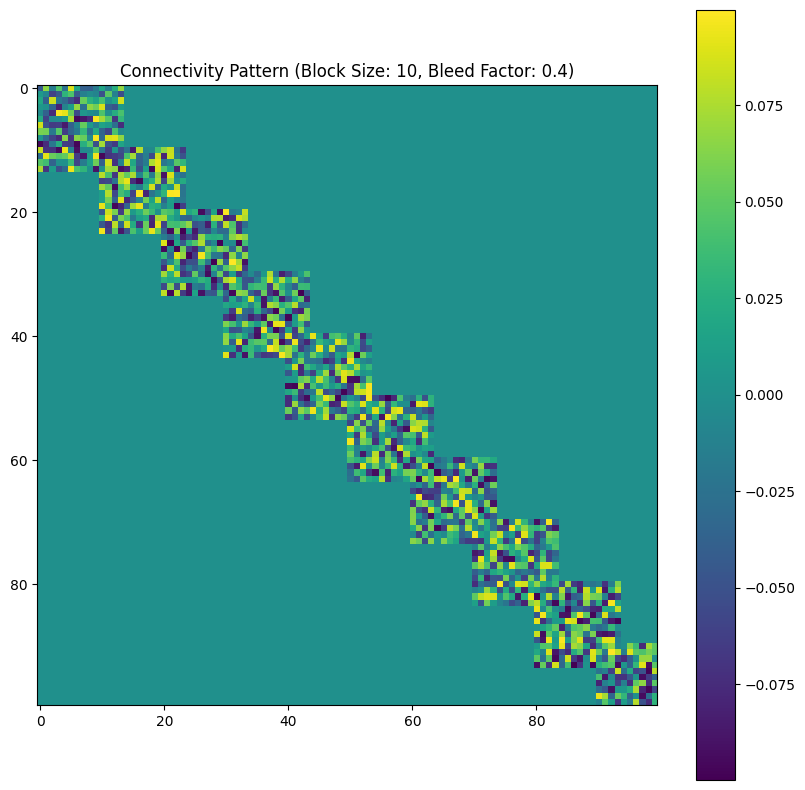

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MaskedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, block_size: int, bleed_factor: float = 0.0, bias: bool = True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.block_size = block_size
        self.bleed_factor = bleed_factor  # New parameter to control bleeding
        self.register_buffer('mask', self.create_mask())

    def create_mask(self):
        mask = torch.zeros(self.weight.size())
        
        # Compute how much additional overlap is allowed based on the bleed factor
        bleed_size = int(self.block_size * self.bleed_factor)

        for i in range(0, self.out_features, self.block_size):
            j = i  # Keep the block diagonal structure
            # Set the mask for the block and the bleed regions
            mask[i:i+self.block_size+bleed_size, j:j+self.block_size+bleed_size] = 1
        
        # Clip the mask to the matrix size (in case of overflow due to bleeding)
        return mask[:self.out_features, :self.in_features]

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.weight * self.mask, self.bias)

    def visualize_connectivity(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.weight.data * self.mask, cmap='viridis')
        plt.title(f'Connectivity Pattern (Block Size: {self.block_size}, Bleed Factor: {self.bleed_factor})')
        plt.colorbar()
        plt.show()

# Usage example:
layer = MaskedLinear(100, 100, block_size=10, bleed_factor=0.4)  # 30% bleed
layer.visualize_connectivity()


In [5]:
# Updated function without prints and assuming label data is passed directly
def is_confident(softmax_output, correct_labels):
    # Convert one-hot encoded labels to indices (get the correct class indices)
    correct_indices = torch.argmax(correct_labels, dim=1)  # [batch_size]
    
    # Gather the softmax probabilities of the correct class for each example in the batch
    correct_class_probs = softmax_output.gather(1, correct_indices.unsqueeze(1)).squeeze()

    # Check if the average of the correct class probabilities is above 90%
    avg_confidence = torch.mean(correct_class_probs)
    
    # Return a boolean indicating if average confidence is over 90%
    return avg_confidence, avg_confidence > 0.90

# Sample scenario

# Simulated softmax output (batch_size = 3, softmax_dim = 4)
softmax_output = torch.tensor([
    [0.1, 0.2, 0.6, 0.1],  # Example 1
    [0.05, 0.8, 0.1, 0.05],  # Example 2
    [0.7, 0.15, 0.1, 0.05]   # Example 3
])

# Simulated label data (batch_size = 3, one_hot_dim = 4)
correct_labels = torch.tensor([
    [0, 0, 1, 0],  # Correct class is index 2
    [0, 1, 0, 0],  # Correct class is index 1
    [1, 0, 0, 0]   # Correct class is index 0
])

# Test the function
is_confident(softmax_output, correct_labels)


(tensor(0.7000), tensor(False))

In [10]:
import torch
import torch.nn.functional as F

def zero_correct_class_softmax(logits, correct_classes):
    # Set a large negative value for logits at the index of the correct class
    modified_logits = logits.clone()  # Clone to avoid modifying original logits in-place
    modified_logits[correct_classes == 1] = -1e9  # Use a very large negative value
    
    # Apply softmax to the modified logits
    softmax_output = F.softmax(modified_logits, dim=1)
    return softmax_output

# Example usage
logits = torch.tensor([[2.0, 1.5, 0.5], [0.5, 2.0, 1.0]], dtype=torch.float32)
correct_classes = torch.tensor([[0, 1, 0], [0, 0, 1]], dtype=torch.float32)  # One-hot encoded correct classes

result = zero_correct_class_softmax(logits, correct_classes)
print(torch.softmax(logits, dim=1))
print(result)


tensor([[0.5465, 0.3315, 0.1220],
        [0.1402, 0.6285, 0.2312]])
tensor([[0.8176, 0.0000, 0.1824],
        [0.1824, 0.8176, 0.0000]])


In [19]:
import torch

# Updated function without prints and assuming label data is passed directly
def is_confident(softmax_output, correct_labels, confidence_threshold):
    # Convert one-hot encoded labels to indices (get the correct class indices)
    correct_indices = torch.argmax(correct_labels, dim=1)  # [batch_size]
    
    # Gather the softmax probabilities of the correct class for each example in the batch
    correct_class_probs = softmax_output.gather(1, correct_indices.unsqueeze(1)).squeeze()

    # Check if all of the correct class probabilities are above the confidence threshold
    all_confident = torch.all(correct_class_probs > confidence_threshold)

    # Calculate the average confidence
    avg_confidence = torch.mean(correct_class_probs)

    # Return the confidence probabilities, average confidence, and whether all are above the threshold
    return avg_confidence.item(), all_confident.item()

# Sample scenario

# Simulated softmax output (batch_size = 3, softmax_dim = 4)
softmax_output = torch.tensor([
    [0.1, 0.2, 0.6, 0.1],  # Example 1
    [0.05, 0.8, 0.1, 0.05],  # Example 2
    [0.7, 0.15, 0.1, 0.05]   # Example 3
])

# Simulated label data (batch_size = 3, one_hot_dim = 4)
correct_labels = torch.tensor([
    [0, 0, 1, 0],  # Correct class is index 2
    [0, 1, 0, 0],  # Correct class is index 1
    [1, 0, 0, 0]   # Correct class is index 0
])

# Test the function
confidence_threshold = 0.8
conf_probs, all_above_threshold = is_confident(softmax_output, correct_labels, confidence_threshold)
conf_probs, all_above_threshold

TypeError: '>' not supported between instances of 'Tensor' and 'str'

In [16]:
import torch

# Function to check the percentage of correct softmax values above a given threshold
def percent_above_threshold(softmax_output, correct_labels, confidence_threshold):
    # Convert one-hot encoded labels to indices (get the correct class indices)
    correct_indices = torch.argmax(correct_labels, dim=1)  # [batch_size]
    
    # Gather the softmax probabilities of the correct class for each example in the batch
    correct_class_probs = softmax_output.gather(1, correct_indices.unsqueeze(1)).squeeze()

    # Check how many of the correct class probabilities are above the confidence threshold
    num_above_threshold = torch.sum(correct_class_probs > confidence_threshold).item()

    # Calculate the percentage of softmax values that are above the threshold
    percent_above = (num_above_threshold / correct_class_probs.size(0)) * 100

    # Return the percentage
    return percent_above

# Sample scenario

# Simulated softmax output (batch_size = 3, softmax_dim = 4)
softmax_output = torch.tensor([
    [0.1, 0.2, 0.6, 0.1],  # Example 1
    [0.05, 0.8, 0.1, 0.05],  # Example 2
    [0.7, 0.15, 0.1, 0.05]   # Example 3
])

# Simulated label data (batch_size = 3, one_hot_dim = 4)
correct_labels = torch.tensor([
    [0, 0, 1, 0],  # Correct class is index 2
    [0, 1, 0, 0],  # Correct class is index 1
    [1, 0, 0, 0]   # Correct class is index 0
])

# Test the function
confidence_threshold = 0.69
percent_above = percent_above_threshold(softmax_output, correct_labels, confidence_threshold)
percent_above

66.66666666666666